In [41]:
import pandas as pd
import numpy as np
import random
import yfinance as yf
import matplotlib.pyplot as plt
from yahoo_fin import stock_info as si
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

### Import the list of symbol from Yahoo Finance for each sector

In [2]:
Symbol = pd.read_excel(r'List_of_Tickers.xlsx', sheet_name='Symbol')
Symbol = pd.DataFrame(Symbol)[['Symbol', 'Name']]
Symbol['sort'] = Symbol['Symbol'].str.len()
Tickers = Symbol.sort_values(['Name', 'sort']).drop_duplicates("Name", keep="first")
Tickers = list(Tickers['Symbol'])

### Import financial data

In [187]:
def FS(tickers):
    lst_of_df = []
    #tickers = [yf.Ticker(ticker) for ticker in tickers]
    for ticker in tickers:
        ticker = yf.Ticker(ticker)
    # get each financial statement
        pnl = ticker.financials
        bs = ticker.balancesheet
        cf = ticker.cashflow

        # concatenate into one dataframe
        fs = pd.concat([pnl, bs, cf])

        # make dataframe format nicer
        # Swap dates and columns
        data = fs.T
        # reset index (date) into a column
        data = data.reset_index()
        # Rename old index from '' to Date
        data.columns = ['Date', *data.columns[1:]]
        # Add needed data to dataframe
        data['Ticker'] = ticker.ticker
        data['Sector'] = ticker.info['sector']
        data['Industry'] = ticker.info['industry']
        data['MarketCap'] = ticker.info['marketCap']
        data['Name'] = ticker.info['shortName']
        data['Country'] = ticker.info['country']
        data = data[['Ticker', 'Name', 'Country', 'Date', 'Sector', 'Industry', 'MarketCap','Depreciation', 'Cost Of Revenue', 'Total Revenue', 'Ebit', 'Interest Expense']]
        lst_of_df.append(data)
        df = pd.concat(lst_of_df)
    return df

In [208]:
financial_data = FS(Tickers)
financial_data

,Ticker,Name,Country,Date,Sector,Industry,MarketCap,Depreciation,Cost Of Revenue,Total Revenue,Ebit,Interest Expense
0,MMM,3M Company,United States,2021-12-31,Industrials,Conglomerates,70192832512,1915000000.0,18776000000.0,35355000000.0,7790000000.0,-488000000.0
1,MMM,3M Company,United States,2020-12-31,Industrials,Conglomerates,70192832512,1911000000.0,16499000000.0,32184000000.0,7156000000.0,-529000000.0
2,MMM,3M Company,United States,2019-12-31,Industrials,Conglomerates,70192832512,1593000000.0,17064000000.0,32136000000.0,6305000000.0,-448000000.0
3,MMM,3M Company,United States,2018-12-31,Industrials,Conglomerates,70192832512,1488000000.0,16655000000.0,32765000000.0,7767000000.0,-350000000.0
0,ABB,ABB Ltd,Switzerland,2021-12-31,Industrials,Electrical Equipment & Parts,59306250240,827000000.0,19407000000.0,28945000000.0,3784000000.0,NaN
1,ABB,ABB Ltd,Switzerland,2020-12-31,Industrials,Electrical Equipment & Parts,59306250240,854000000.0,18123000000.0,26134000000.0,1816000000.0,-448000000.0
2,ABB,ABB Ltd,Switzerland,2019-12-31,Industrials,Electrical Equipment & Parts,59306250240,887000000.0,19018000000.0,27978000000.0,2460000000.0,-93000000.0
3,ABB,ABB Ltd,Switzerland,2018-12-31,Industrials,Electrical Equipment & Parts,59306250240,857000000.0,19059000000.0,27662000000.0,2370000000.0,-305000000.0
0,ASML,ASML Holding N.V. - New York Re,Netherlands,2021-12-31,Technology,Semiconductor Equipment & Materials,244184121344,457500000.0,8802000000.0,18611000000.0,6536400000.0,-54600000.0
1,ASML,ASML Holding N.V. - New York Re,Netherlands,2020-12-31,Technology,Semiconductor Equipment & Materials,244184121344,393100000.0,7181300000.0,13978500000.0,4051500000.0,-43300000.0


### Calculate leverage data
     Total Leverage =  DOL * DFL
     DFL = Ebit/Ebt
     Ebt = Ebit - Interest Expense
     DOL = ((Ebit(t) - Ebit(t-1)/Ebit(t-1))/((Revenue(t)-Revenue(t-1)/(Revenue(t-1))

In [189]:
def get_leverage(financial_data):
    df = financial_data.dropna()
    df['Ebt'] = df['Ebit'] + df['Interest Expense']
    df['Ebit_t-1'] = df['Ebit'].shift(-1)
    df['Total Revenue_t-1'] = df['Total Revenue'].shift(-1)
    df['Ticker_lag'] = df['Ticker'].shift(-1)
    df = df[df.Ticker == df.Ticker_lag]
    df['DFL'] = df['Ebit']/df['Ebt']
    df['DOL'] = ((df['Ebit'] - df['Ebit_t-1'])/df['Ebit_t-1']) \
                /((df['Total Revenue'] - df['Total Revenue_t-1'])/df['Total Revenue_t-1'])
    df['Total Leverage'] = df['DFL'] * df['DOL']
    df['Year'] = df['Date'].dt.year
    return df
leverage_data = get_leverage(financial_data)  
#leverage_data.to_csv('leverage_sampledata.csv', index=False, header=True)
leverage_data

,Ticker,Name,Country,Date,Sector,Industry,MarketCap,Depreciation,Cost Of Revenue,Total Revenue,Ebit,Interest Expense,Ebt,Ebit_t-1,Total Revenue_t-1,Ticker_lag,DFL,DOL,Total Leverage,Year
0,MMM,3M Company,United States,2021-12-31,Industrials,Conglomerates,69640085504,1915000000.0,18776000000.0,35355000000.0,7790000000.0,-488000000.0,7302000000.0,7156000000.0,32184000000.0,MMM,1.066831,0.899213,0.959309,2021
1,MMM,3M Company,United States,2020-12-31,Industrials,Conglomerates,69640085504,1911000000.0,16499000000.0,32184000000.0,7156000000.0,-529000000.0,6627000000.0,6305000000.0,32136000000.0,MMM,1.079825,90.363918,97.577213,2020
2,MMM,3M Company,United States,2019-12-31,Industrials,Conglomerates,69640085504,1593000000.0,17064000000.0,32136000000.0,6305000000.0,-448000000.0,5857000000.0,7767000000.0,32765000000.0,MMM,1.07649,9.805135,10.555127,2019
1,ABB,ABB Ltd,Switzerland,2020-12-31,Industrials,Electrical Equipment & Parts,59559714816,854000000.0,18123000000.0,26134000000.0,1816000000.0,-448000000.0,1368000000.0,2460000000.0,27978000000.0,ABB,1.327485,3.971975,5.272739,2020
2,ABB,ABB Ltd,Switzerland,2019-12-31,Industrials,Electrical Equipment & Parts,59559714816,887000000.0,19018000000.0,27978000000.0,2460000000.0,-93000000.0,2367000000.0,2370000000.0,27662000000.0,ABB,1.03929,3.324227,3.454837,2019
0,ASML,ASML Holding N.V. - New York Re,Netherlands,2021-12-31,Technology,Semiconductor Equipment & Materials,250154483712,457500000.0,8802000000.0,18611000000.0,6536400000.0,-54600000.0,6481800000.0,4051500000.0,13978500000.0,ASML,1.008424,1.850709,1.866299,2021
1,ASML,ASML Holding N.V. - New York Re,Netherlands,2020-12-31,Technology,Semiconductor Equipment & Materials,250154483712,393100000.0,7181300000.0,13978500000.0,4051500000.0,-43300000.0,4008200000.0,2790800000.0,11820000000.0,ASML,1.010803,2.473708,2.500431,2020
2,ASML,ASML Holding N.V. - New York Re,Netherlands,2019-12-31,Technology,Semiconductor Equipment & Materials,250154483712,366000000.0,6540200000.0,11820000000.0,2790800000.0,-36600000.0,2754200000.0,2965300000.0,10944000000.0,ASML,1.013289,-0.735189,-0.744958,2019
0,T,AT&T Inc.,United States,2021-12-31,Communication Services,Telecom Services,136767135744,19841000000.0,79807000000.0,168864000000.0,36905000000.0,-6884000000.0,30021000000.0,25656000000.0,171760000000.0,T,1.229306,-26.004496,-31.967487,2021
1,T,AT&T Inc.,United States,2020-12-31,Communication Services,Telecom Services,136767135744,25033000000.0,79920000000.0,171760000000.0,25656000000.0,-7925000000.0,17731000000.0,27741000000.0,181193000000.0,T,1.446957,1.443695,2.088965,2020


In [190]:
leverage_data = pd.read_csv('leverage_data.csv')
leverage_data

,Ticker,Name,Country,Date,Sector,Industry,MarketCap,Depreciation,Cost Of Revenue,Total Revenue,Ebit,Interest Expense,Ebt,Ebit_t-1,Total Revenue_t-1,Ticker_lag,DFL,DOL,Total Leverage,Year
0,MMM,3M Company,United States,2021/12/31,Industrials,Conglomerates,6.962903e+10,1.915000e+09,1.877600e+10,3.535500e+10,7.790000e+09,-4.880000e+08,7.302000e+09,7.156000e+09,3.218400e+10,MMM,1.066831,0.899213,0.959309,2021
1,MMM,3M Company,United States,2020/12/31,Industrials,Conglomerates,6.962903e+10,1.911000e+09,1.649900e+10,3.218400e+10,7.156000e+09,-5.290000e+08,6.627000e+09,6.305000e+09,3.213600e+10,MMM,1.079825,90.363918,97.577213,2020
2,MMM,3M Company,United States,2019/12/31,Industrials,Conglomerates,6.962903e+10,1.593000e+09,1.706400e+10,3.213600e+10,6.305000e+09,-4.480000e+08,5.857000e+09,7.767000e+09,3.276500e+10,MMM,1.076490,9.805135,10.555127,2019
3,ABB,ABB Ltd,Switzerland,2020/12/31,Industrials,Electrical Equipment & Parts,5.942761e+10,8.540000e+08,1.812300e+10,2.613400e+10,1.816000e+09,-4.480000e+08,1.368000e+09,2.460000e+09,2.797800e+10,ABB,1.327485,3.971975,5.272739,2020
4,ABB,ABB Ltd,Switzerland,2019/12/31,Industrials,Electrical Equipment & Parts,5.942761e+10,8.870000e+08,1.901800e+10,2.797800e+10,2.460000e+09,-9.300000e+07,2.367000e+09,2.370000e+09,2.766200e+10,ABB,1.039290,3.324227,3.454837,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,ZTS,Zoetis Inc.,United States,2020/12/31,Healthcare,Drug Manufacturers—Specialty & Generic,7.289832e+10,3.950000e+08,2.038000e+09,6.675000e+09,2.301000e+09,-2.310000e+08,2.070000e+09,2.097000e+09,6.260000e+09,ZTS,1.111594,1.467432,1.631189,2020
998,ZTS,Zoetis Inc.,United States,2019/12/31,Healthcare,Drug Manufacturers—Specialty & Generic,7.289832e+10,3.850000e+08,1.915000e+09,6.260000e+09,2.097000e+09,-2.230000e+08,1.874000e+09,1.891000e+09,5.825000e+09,ZTS,1.118997,1.458755,1.632342,2019
999,DOGEF,ORSTED A/S,Denmark,2021/12/31,Utilities,Utilities—Renewable,3.972986e+10,7.972000e+09,5.311000e+10,7.767300e+10,1.042100e+10,-1.841000e+09,8.580000e+09,8.134000e+09,5.015100e+10,DOGEF,1.214569,0.512344,0.622277,2021
1000,DOGEF,ORSTED A/S,Denmark,2020/12/31,Utilities,Utilities—Renewable,3.972986e+10,7.588000e+09,2.578400e+10,5.015100e+10,8.134000e+09,-2.106000e+09,6.028000e+09,1.227700e+10,7.039800e+10,DOGEF,1.349370,1.173336,1.583264,2020


### visualization

In [229]:
pd.set_option('display.max_rows', None)
leverage_data.groupby(['Sector','Industry'])['Industry','Ticker'].count()

Industry  \
Sector                 Industry                                           
Basic Materials        Agricultural Inputs                            9   
                       Building Materials                             6   
                       Chemicals                                      8   
                       Copper                                         6   
                       Gold                                          12   
                       Other Industrial Metals & Mining              21   
                       Other Precious Metals & Mining                 3   
                       Specialty Chemicals                           36   
                       Steel                                          3   
Communication Services Electronic Gaming & Multimedia                11   
                       Entertainment                                  9   
                       Internet Content & Information                15   
                       Publishing                                     3   
                       Telecom Services                              51   
Consumer Cyclical      Apparel Retail                                 9   
                       Auto Manufacturers                            27   
                       Footwear & Accessories                         3   
                       Home Improvement Retail                        6   
                       Internet Retail                               15   
                       Leisure                                        3   
                       Lodging                                        3   
                       Luxury Goods                                  18   
                       Restaurants                                    6   
                       Specialty Retail                               9   
                       Travel Services                                3   
Consumer Defensive     Beverages—Brewers                             12   
                       Beverages—Non-Alcoholic                       12   
                       Beverages—Wineries & Distilleries              9   
                       Confectioners                                  6   
                       Discount Stores                               15   
                       Farm Products                                  3   
                       Food Distribution                              3   
                       Grocery Stores                                 6   
                       Household & Personal Products                 21   
                       Packaged Foods                                 9   
                       Tobacco                                       12   
Energy                 Oil & Gas E&P                                 24   
                       Oil & Gas Equipment & Services                 9   
                       Oil & Gas Integrated                          39   
                       Oil & Gas Midstream                           30   
                       Oil & Gas Refining & Marketing                12   
                       Thermal Coal                                   3   
Financial Services     Asset Management                               3   
                       Credit Services                                6   
                       Financial Data & Stock Exchanges               3   
                       Insurance—Diversified                          3   
                       Insurance—Life                                 6   
Healthcare             Biotechnology                                 15   
                       Diagnostics & Research                         6   
                       Drug Manufacturers—General                    45   
                       Drug Manufacturers—Specialty & Generic         6   
                       Healthcare Plans                              15   
             

In [191]:
leverage_data.nunique()

Ticker                336
Name                  336
Country                26
Date                   68
Sector                 11
Industry               86
MarketCap             315
Depreciation          962
Cost Of Revenue       952
Total Revenue         952
Ebit                  971
Interest Expense      867
Ebt                   974
Ebit_t-1              978
Total Revenue_t-1     950
Ticker_lag            336
DFL                  1002
DOL                   999
Total Leverage       1002
Year                    4
dtype: int64

In [193]:
list_of_sector = list(leverage_data.Sector.unique())
list_of_sector

['Industrials',
 'Technology',
 'Communication Services',
 'Healthcare',
 'Basic Materials',
 'Consumer Cyclical',
 'Real Estate',
 'Consumer Defensive',
 'Utilities',
 'Energy',
 'Financial Services']

In [241]:
total_leverage = dt[['Year','Sector', 'Total Leverage']]
total_leverage = total_leverage.reset_index(drop=True).pivot_table(index='Year', columns='Sector', values='Total Leverage')
total_leverage

Sector,Basic Materials,Communication Services,Consumer Cyclical,Consumer Defensive,Energy,Financial Services,Healthcare,Industrials,Real Estate,Technology,Utilities
Year,,,,,,,,,,,
2019,8.235162,-0.459626,-4.408289,-4.072561,17.223778,1.739188,4.251228,2.576913,-0.482850,-0.785382,-3.802607
2020,-2.617930,-17.166856,14.636895,0.561789,3.776588,0.925989,3.824635,4.627179,4.057423,2.156960,-5.029375
2021,2.486184,0.836434,2.259358,0.595197,-1.718221,2.121155,-1.682630,34.041171,-3.087376,1.568985,6.965790
2022,1.005973,3.474524,10.705286,0.511481,NaN,1.166575,2.228072,2.857280,2.158055,1.415106,3.329144


In [242]:
dol = dt[['Year','Sector', 'DOL']]
dol = dol.reset_index(drop=True).pivot_table(index='Year', columns='Sector', values='DOL')
dol

Sector,Basic Materials,Communication Services,Consumer Cyclical,Consumer Defensive,Energy,Financial Services,Healthcare,Industrials,Real Estate,Technology,Utilities
Year,,,,,,,,,,,
2019,3.773005,-0.031626,-3.591714,-3.407779,11.569240,1.478255,3.523082,1.437559,-0.657626,-0.776925,6.612334
2020,-1.326309,-14.360305,14.188631,0.354636,3.749354,0.899231,3.380744,4.473487,4.733827,2.112751,-3.800480
2021,2.400354,0.750691,3.517574,0.993813,-1.168000,1.900717,-1.462672,16.560509,-1.037397,1.532170,5.365434
2022,0.987448,2.134347,10.417789,0.400479,NaN,1.134773,2.018129,2.721041,1.941755,1.381025,2.753726


In [243]:
dfl = dt[['Year','Sector', 'DFL']]
dfl = dfl.reset_index(drop=True).pivot_table(index='Year', columns='Sector', values='DFL')
dfl

Sector,Basic Materials,Communication Services,Consumer Cyclical,Consumer Defensive,Energy,Financial Services,Healthcare,Industrials,Real Estate,Technology,Utilities
Year,,,,,,,,,,,
2019,1.495746,1.277277,1.068513,1.155281,1.293769,1.094903,1.140262,1.286680,0.893290,1.011007,2.680586
2020,1.137061,1.266638,1.681467,1.179948,1.278577,1.090106,1.139618,1.226442,1.396140,1.025969,1.523287
2021,1.072387,1.264545,1.622128,1.157986,1.489539,1.111913,1.092954,1.152718,1.247123,1.023346,1.482184
2022,1.029000,1.180103,1.057609,1.109080,NaN,1.028025,1.067325,1.050079,1.097374,1.024798,1.234596


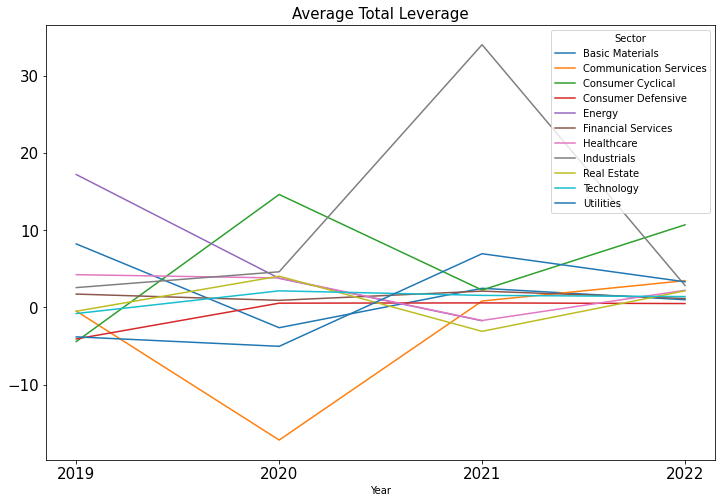

In [244]:
plt.rcParams['figure.figsize'] = [12, 8]
total_leverage.plot(fontsize=15)
plt.title("Average Total Leverage", fontsize = 15)
plt.xticks(np.arange(2019, 2023, 1))
plt.show()

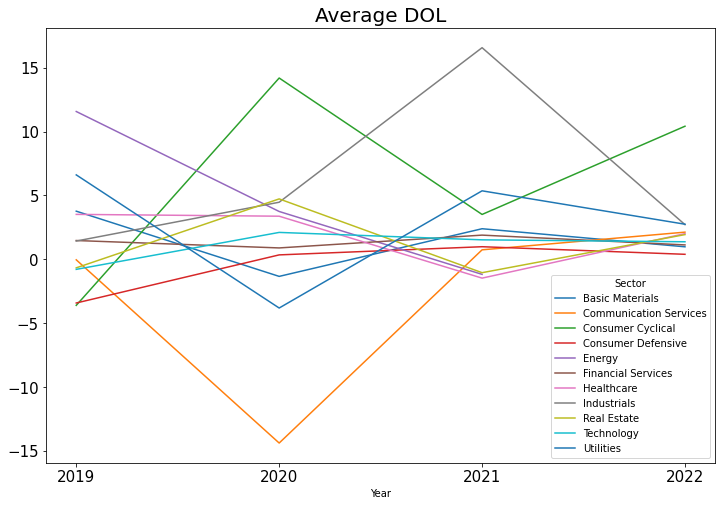

In [245]:
dol.plot(fontsize=15)
plt.title("DOL", fontsize = 15)
plt.title("Average DOL", fontsize = 20)
plt.xticks(np.arange(2019, 2023, 1))
plt.show()

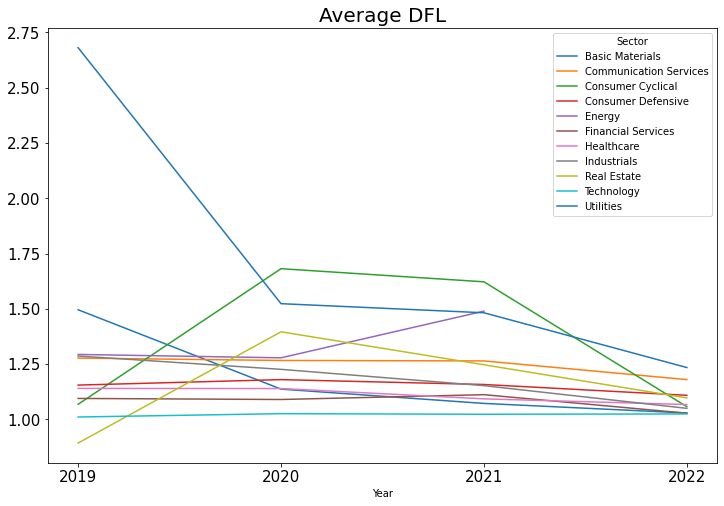

In [246]:
dfl.plot(fontsize=15)
plt.title("Average DFL", fontsize = 20)
plt.xticks(np.arange(2019, 2023, 1))
plt.show()

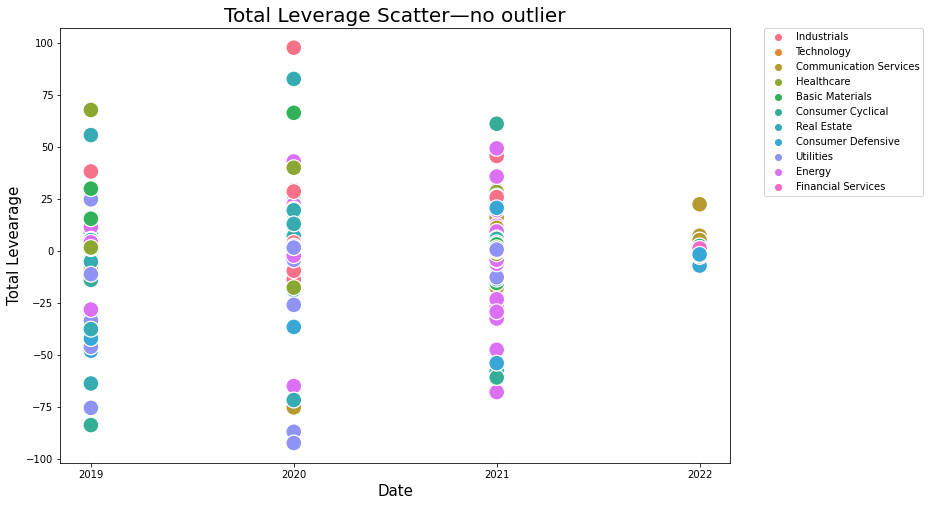

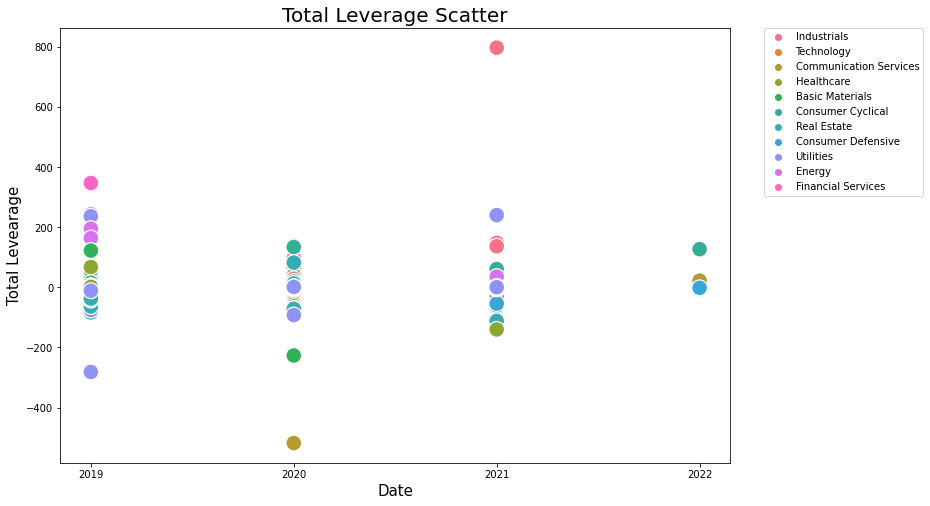

In [217]:
import seaborn as sns

leverage_data_no_outlier = leverage_data[leverage_data['Total Leverage'] > -100]
leverage_data_no_outlier = leverage_data_no_outlier[leverage_data_no_outlier['Total Leverage'] < 100]
plt.figure(figsize=(12,8))
plot = sns.scatterplot(data=leverage_data_no_outlier, x="Year", y="Total Leverage", hue="Sector", s=250)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Total Leverage Scatter—no outlier", fontsize = 20)
plot.set_xlabel("Date",fontsize=15)
plot.set_ylabel("Total Levearage",fontsize=15)
plt.xticks(np.arange(2019, 2023, 1))
plt.show()

plt.figure(figsize=(12,8))
plot = sns.scatterplot(data=leverage_data, x="Year", y="Total Leverage", hue="Sector", s=250)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Total Leverage Scatter", fontsize = 20)
plot.set_xlabel("Date",fontsize=15)
plot.set_ylabel("Total Levearage",fontsize=15)
plt.xticks(np.arange(2019, 2023, 1))
plt.show()

In [216]:
Companies_outlier_leverage = leverage_data[leverage_data['Total Leverage'] > 300]
Companies_outlier_leverage = Companies_outlier_leverage.append(leverage_data[leverage_data['Total Leverage'] < -300])
Companies_outlier_leverage

,Ticker,Name,Country,Date,Sector,Industry,MarketCap,Depreciation,Cost Of Revenue,Total Revenue,Ebit,Interest Expense,Ebt,Ebit_t-1,Total Revenue_t-1,Ticker_lag,DFL,DOL,Total Leverage,Year
26,GE,General Electric Company,United States,2021/12/31,Industrials,Specialty Industrial Machinery,9.378932e+10,3.009000e+09,5.578500e+10,7.419600e+10,2.704000e+09,-1.876000e+09,8.280000e+08,-6.320000e+08,7.583400e+10,GE,3.265700,244.376269,798.059701,2021
117,BRK-A,Berkshire Hathaway Inc.,United States,2019/12/31,Financial Services,Insurance—Diversified,7.000000e+11,1.006400e+10,1.490000e+11,2.550000e+11,1.060000e+11,-3.961000e+09,1.020000e+11,1.040300e+10,2.480000e+11,BRK-A,1.038980,334.472359,347.510119,2019
992,BIDU,"Baidu, Inc.",China,2020/12/31,Communication Services,Internet Content & Information,3.736920e+10,1.782700e+10,5.400300e+10,1.070000e+11,1.549500e+10,-3.103000e+09,1.239200e+10,6.713000e+09,1.070000e+11,BIDU,1.250403,-414.508971,-518.303462,2020


In [204]:
by_sector = leverage_data.groupby('Sector').mean().reset_index()
by_sector

,Sector,MarketCap,Depreciation,Cost Of Revenue,Total Revenue,Ebit,Interest Expense,Ebt,Ebit_t-1,Total Revenue_t-1,DFL,DOL,Total Leverage,Year
0,Basic Materials,5.542622e+10,5.144800e+09,4.425817e+10,6.844124e+10,1.696029e+10,-6.908967e+08,1.626561e+10,1.397323e+10,6.381924e+10,1.219094,1.514587,2.439393,2020.096154
1,Communication Services,1.307153e+11,1.421712e+11,6.697233e+11,1.110808e+12,1.832091e+11,-1.765532e+10,1.654827e+11,1.795528e+11,1.109726e+12,1.257532,-4.338901,-5.182722,2020.359551
2,Consumer Cyclical,1.550799e+11,5.424649e+10,8.254956e+11,1.048167e+12,9.046943e+10,-2.121330e+09,8.832579e+10,8.458188e+10,1.022136e+12,1.455980,6.490355,6.088895,2020.382353
3,Consumer Defensive,1.138163e+11,1.608731e+10,2.112629e+11,3.431294e+11,3.305388e+10,-2.449395e+09,3.060138e+10,3.309087e+10,3.193455e+11,1.158844,-0.228042,-0.420075,2020.361111
4,Energy,8.412635e+10,1.622510e+10,1.371589e+11,1.898541e+11,1.301982e+10,-2.479983e+09,1.054019e+10,1.122208e+10,1.884027e+11,1.353832,4.650028,6.312448,2020.008547
5,Financial Services,2.811429e+11,4.698190e+09,2.402425e+11,3.389945e+11,5.769371e+10,-6.522000e+09,5.120738e+10,5.177695e+10,3.132097e+11,1.088263,17.832942,18.625514,2020.142857
6,Healthcare,1.606745e+11,4.047115e+09,3.769047e+10,7.926433e+10,1.156382e+10,-7.791144e+08,1.077842e+10,1.042637e+10,7.224013e+10,1.120341,1.733652,2.025561,2020.153153
7,Industrials,8.367409e+10,4.789349e+10,1.021358e+12,1.269531e+12,6.429486e+10,-5.316439e+09,5.900051e+10,5.873594e+10,1.224705e+12,1.200862,7.578177,13.692014,2020.267857
8,Real Estate,3.207800e+10,8.375502e+09,1.802155e+11,2.345891e+11,3.000163e+10,-2.282008e+09,2.771301e+10,2.964950e+10,2.249984e+11,1.185413,1.114063,0.274535,2020.125000
9,Technology,1.067800e+12,7.360757e+10,1.853460e+11,3.761944e+11,1.417022e+11,-1.784673e+09,1.399390e+11,1.171487e+11,3.236034e+11,1.022866,1.387589,1.420286,2020.600000


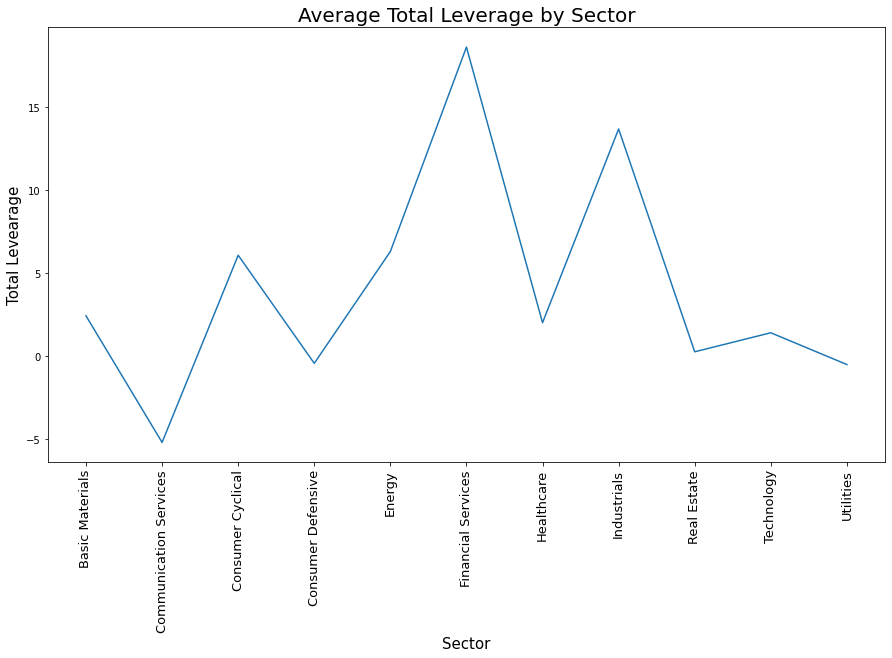

In [205]:
plt.figure(figsize=(15,8))
plot = sns.lineplot(data=by_sector, x="Sector", y="Total Leverage")
plot.axes.set_title("Average Total Leverage by Sector",fontsize=20)
plot.set_xlabel("Sector",fontsize=15)
plot.set_ylabel("Total Levearage",fontsize=15)
plt.setp(plot.get_xticklabels(), rotation=90, fontsize=13)
plt.show()

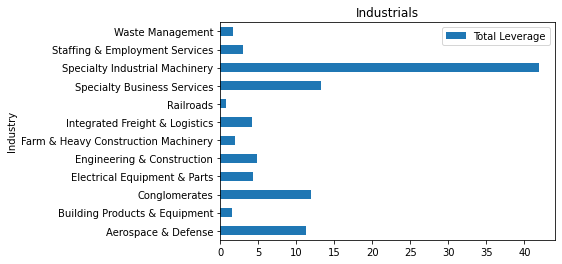

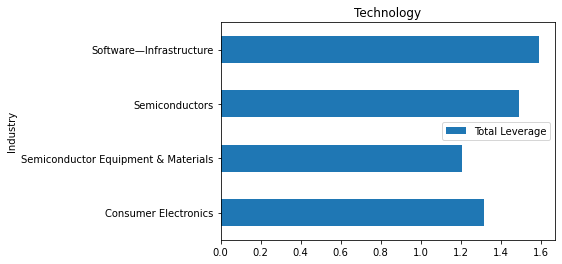

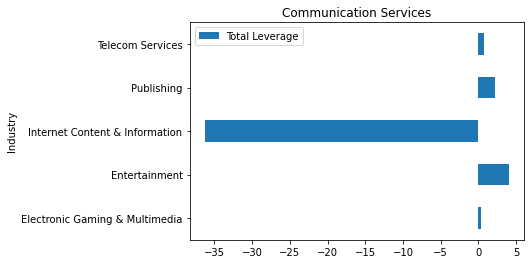

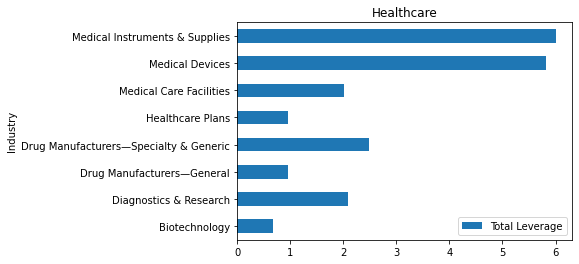

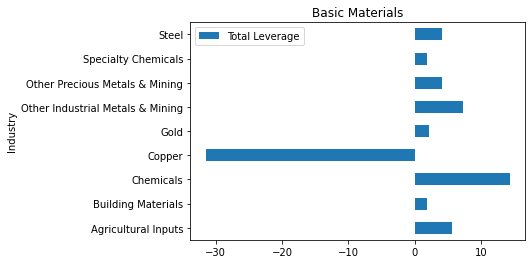

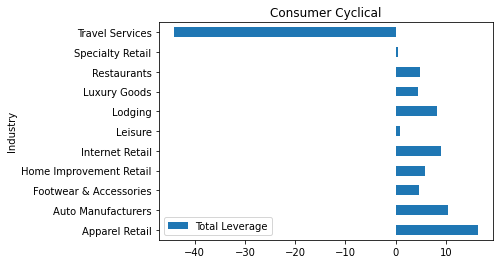

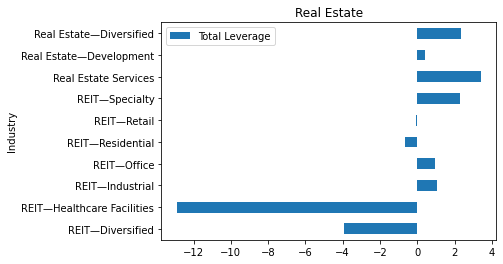

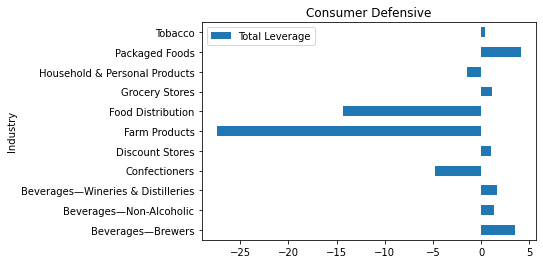

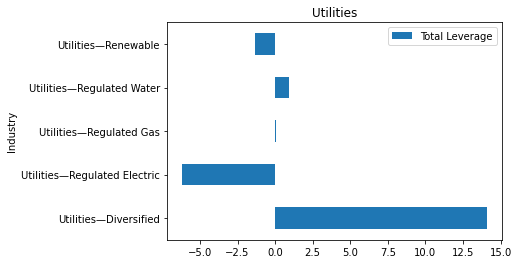

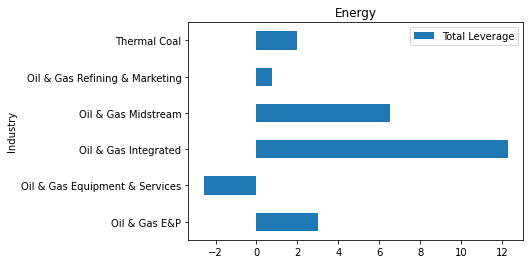

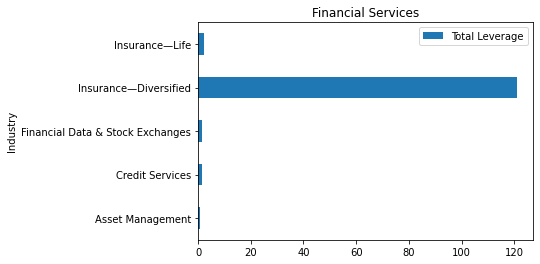

In [206]:
by_industry = []
for i in range(len(list_of_sector)):
    df = leverage_data[leverage_data['Sector']==list_of_sector[i]][['Sector', 'Industry', 'Total Leverage']]\
                       .groupby('Industry').mean().reset_index()
    df['Sector'] = list_of_sector[i]
    plt.rcParams['figure.figsize'] = [6, 4]
    df.plot.barh(x='Industry', y='Total Leverage', title = list_of_sector[i])